<a href="https://colab.research.google.com/github/RamezNabil/Disaster-Tweets-Classifcation/blob/main/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict which Tweets are about real disasters and which ones are not using different models

##Setting up Kaggle api

In [1]:
!pip install -q kaggle

In [ ]:
# Upload your Kaggle API json file
from google.colab import files
files.upload()

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-08-16 08:33:52          10801  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6601  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2498  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2666  
promptcloud/car

##Downloading the dataset and Imports

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 39.2MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.6MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.5MB/s]


In [5]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

##Pre-procesing

In [6]:
# Setting random seed to get stable results
tf.random.set_seed(42)

In [7]:
# Reading csv into pandas dataframe
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

# Shuffle training dataframe
train_data = train_data.sample(frac=1, random_state=42)

In [8]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data['text'].to_numpy(),
                                                    train_data['target'].to_numpy(),
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
# Checking Classes distribution
pd.DataFrame(y_train).value_counts(), pd.DataFrame(y_test).value_counts()

(0    3484
 1    2606
 dtype: int64, 0    858
 1    665
 dtype: int64)

### Vectorization (Tokenization)

In [10]:
# Getting the highest number of lines in 95% of the data
VOCAB_LEN = 10000
PERCENTILE = 95
sentences_len = [len(sentence.split()) for sentence in X_train]
output_seq_len = int(np.percentile(sentences_len, PERCENTILE))
output_seq_len

24

In [11]:
# Building and adapting the text vectorizer
vectorizer = TextVectorization(max_tokens=VOCAB_LEN, output_sequence_length=output_seq_len)
vectorizer.adapt(X_train)

In [12]:
# Testing the vectorizer
random_sample = random.choice(X_train)
print(f"Sentence: {random_sample}\n\nTokenized: {vectorizer([random_sample])}")

Sentence: HEALTH FACT: 75% of muscle mass is made up of fluid. Drink water to prevent strains sprains and other injuries. http://t.co/g0dN1ChLUo

Tokenized: [[ 631 1186 5810    6 2629  153    9  273   28    6 5157 1415  179    5
  1374 7423 7559    7  526  262    1    0    0    0]]


In [13]:
# Vectorizer vocab length
vectorizer.vocabulary_size()

10000

### Embedding

In [14]:
def Create_embedding_layer():
  """
  Creates and returns a new embedding layer
  """
  embedding = layers.Embedding(input_dim=vectorizer.vocabulary_size(),
                             output_dim=128,
                             input_length=output_seq_len)
  return embedding

In [15]:
# Testing the embedding
random_sample = random.choice(X_train)
embedding = Create_embedding_layer()
print(f"Sentence: {random_sample}\n\nEmbedded: {embedding(vectorizer([random_sample]))}")

Sentence: New: NYC Legionnaires' disease death toll rises http://t.co/NqL21ajmiv #follow (http://t.co/18xQ3FmuGE)

Embedded: [[[-0.02769482 -0.02347138 -0.00921988 ... -0.02134148 -0.01753038
    0.01562332]
  [ 0.02423469  0.02318385 -0.00542399 ...  0.00210809  0.04559363
   -0.0365983 ]
  [ 0.04794505 -0.00881048 -0.00582109 ...  0.00414313 -0.01196804
   -0.02754842]
  ...
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381
   -0.00024097]
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381
   -0.00024097]
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381
   -0.00024097]]]


### TensorBoard callback

In [16]:
import datetime
def create_tensorboard_callback(experiment_name, dir_name = "TensorBoard_Experiments"):
  """
  Creates a TensorBoard callback instance to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Model 1 (LSTM)
* 78.00% accuracy
* Overfitting

Saving TensorBoard log files to: TensorBoard_Experiments/LSTM/20210817-181936
Epoch 1/5
191/191 [==============================] - 11s 14ms/step - loss: 0.5399 - accuracy: 0.7256 - val_loss: 0.4518 - val_accuracy: 0.7945
Epoch 2/5
191/191 [==============================] - 1s 7ms/step - loss: 0.3160 - accuracy: 0.8773 - val_loss: 0.4831 - val_accuracy: 0.7853
Epoch 3/5
191/191 [==============================] - 1s 7ms/step - loss: 0.2146 - accuracy: 0.9261 - val_loss: 0.5860 - val_accuracy: 0.7879
Epoch 4/5
191/191 [==============================] - 1s 7ms/step - loss: 0.1539 - accuracy: 0.9489 - val_loss: 0.8111 - val_accuracy: 0.7564
Epoch 5/5
191/191 [==============================] - 1s 7ms/step - loss: 0.1045 - accuracy: 0.9608 - val_loss: 0.7784 - val_accuracy: 0.7800


Text(0.5, 0, 'Epochs')

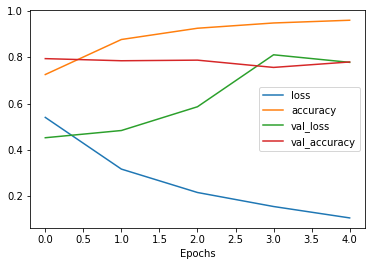

In [17]:
# Create model
inputs = layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
embedding = Create_embedding_layer()
x = embedding(x)
x = layers.LSTM(64)(x)
output = layers.Dense(1, "sigmoid")(x)
model_1 = tf.keras.Model(inputs, output)

# Compile model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit model
history_1 = model_1.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test),
                        callbacks=[create_tensorboard_callback("LSTM")])

# Plot validation accuracy
pd.DataFrame(history_1.history).plot();
plt.xlabel("Epochs")

## Model 2 (GRU)
* 78.27% accuracy
* Overfitting

Saving TensorBoard log files to: TensorBoard_Experiments/GRU/20210817-181959
Epoch 1/5
191/191 [==============================] - 4s 12ms/step - loss: 0.6384 - accuracy: 0.6194 - val_loss: 0.4806 - val_accuracy: 0.7768
Epoch 2/5
191/191 [==============================] - 1s 7ms/step - loss: 0.3846 - accuracy: 0.8335 - val_loss: 0.4645 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 1s 7ms/step - loss: 0.2417 - accuracy: 0.9115 - val_loss: 0.5328 - val_accuracy: 0.7925
Epoch 4/5
191/191 [==============================] - 1s 6ms/step - loss: 0.1655 - accuracy: 0.9452 - val_loss: 0.6053 - val_accuracy: 0.7617
Epoch 5/5
191/191 [==============================] - 1s 6ms/step - loss: 0.1174 - accuracy: 0.9622 - val_loss: 0.6247 - val_accuracy: 0.7827


Text(0.5, 0, 'Epochs')

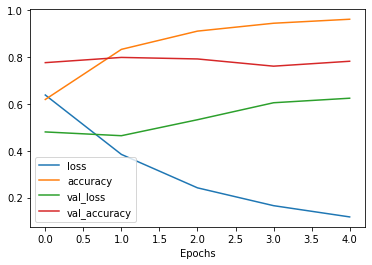

In [18]:
# Create model
inputs = layers.Input((1,), dtype="string")
x = vectorizer(inputs)
embedding = Create_embedding_layer()
x = embedding(x)
x = layers.GRU(64)(x)
output = layers.Dense(1, "sigmoid")(x)
model_2 = tf.keras.Model(inputs, output)

# Compile model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit model
history_2 = model_2.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test),
                        callbacks=[create_tensorboard_callback("GRU")])

# Plot validation accuracy
pd.DataFrame(history_2.history).plot();
plt.xlabel("Epochs")

## Model 3 (Bi-LSTM)
* 78.66% accuracy
* Overfitting

Saving TensorBoard log files to: TensorBoard_Experiments/Bi_LSTM/20210817-182009
Epoch 1/5
191/191 [==============================] - 6s 16ms/step - loss: 0.5245 - accuracy: 0.7396 - val_loss: 0.4536 - val_accuracy: 0.8011
Epoch 2/5
191/191 [==============================] - 2s 10ms/step - loss: 0.3036 - accuracy: 0.8703 - val_loss: 0.4836 - val_accuracy: 0.8056
Epoch 3/5
191/191 [==============================] - 2s 9ms/step - loss: 0.1963 - accuracy: 0.9263 - val_loss: 0.5761 - val_accuracy: 0.7833
Epoch 4/5
191/191 [==============================] - 2s 9ms/step - loss: 0.1328 - accuracy: 0.9519 - val_loss: 0.6132 - val_accuracy: 0.7676
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.0954 - accuracy: 0.9645 - val_loss: 0.7981 - val_accuracy: 0.7827


Text(0.5, 0, 'Epochs')

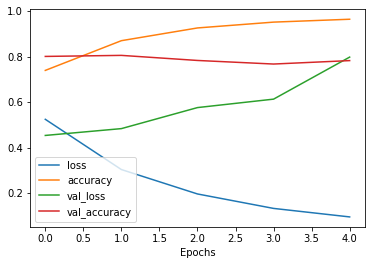

In [19]:
# Build model
inputs = layers.Input((1,), dtype="string")
x = vectorizer(inputs)
embedding = Create_embedding_layer()
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = layers.Dense(1, "sigmoid")(x)
model_3 = tf.keras.Model(inputs, output)

# Compile model
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit model
history_3 = model_3.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test),
                        callbacks=[create_tensorboard_callback("Bi_LSTM")])

# Plot validation accuracy
pd.DataFrame(history_3.history).plot();
plt.xlabel("Epochs")

## Model 4 (1D CNN)
* 78.73% accuracy
* Overfitting

Saving TensorBoard log files to: TensorBoard_Experiments/CNN/20210817-182023
Epoch 1/5
191/191 [==============================] - 28s 11ms/step - loss: 0.5809 - accuracy: 0.7140 - val_loss: 0.4733 - val_accuracy: 0.7899
Epoch 2/5
191/191 [==============================] - 1s 5ms/step - loss: 0.3466 - accuracy: 0.8599 - val_loss: 0.4697 - val_accuracy: 0.7991
Epoch 3/5
191/191 [==============================] - 1s 5ms/step - loss: 0.2057 - accuracy: 0.9289 - val_loss: 0.5236 - val_accuracy: 0.7886
Epoch 4/5
191/191 [==============================] - 1s 5ms/step - loss: 0.1268 - accuracy: 0.9585 - val_loss: 0.5936 - val_accuracy: 0.7676
Epoch 5/5
191/191 [==============================] - 1s 5ms/step - loss: 0.0881 - accuracy: 0.9713 - val_loss: 0.6547 - val_accuracy: 0.7827


Text(0.5, 0, 'Epochs')

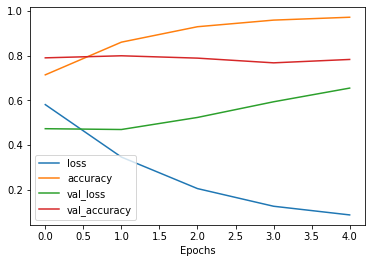

In [20]:
# Build Model
inputs = layers.Input((1,), dtype="string")
x = vectorizer(inputs)
embedding = Create_embedding_layer()
x = embedding(x)
x = layers.Conv1D(32, 5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
output = layers.Dense(1, "sigmoid")(x)
model_4 = tf.keras.Model(inputs, output)

# Compile model
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit model
history_4 = model_4.fit(X_train, y_train, epochs=5,
                        validation_data=(X_test, y_test),
                        callbacks=[create_tensorboard_callback("CNN")])

# Plot validation accuracy
pd.DataFrame(history_4.history).plot();
plt.xlabel("Epochs")

## Model 5 (Universal Sentence Encoder)
* 79.45% accuracy
* Overfitting

Saving TensorBoard log files to: TensorBoard_Experiments/USE/20210817-182120
Epoch 1/10
191/191 [==============================] - 7s 23ms/step - loss: 0.4873 - accuracy: 0.7704 - val_loss: 0.5940 - val_accuracy: 0.7236
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3925 - accuracy: 0.8273 - val_loss: 0.4973 - val_accuracy: 0.8122
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3587 - accuracy: 0.8427 - val_loss: 0.4448 - val_accuracy: 0.8102
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3207 - accuracy: 0.8616 - val_loss: 0.4664 - val_accuracy: 0.8017
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.2947 - accuracy: 0.8742 - val_loss: 0.4926 - val_accuracy: 0.8037
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.2713 - accuracy: 0.8901 - val_loss: 0.5088 - val_accuracy: 0.8083
Epoch 7/10
191/191 [==============================] - 3s 13ms/ste

Text(0.5, 0, 'Epochs')

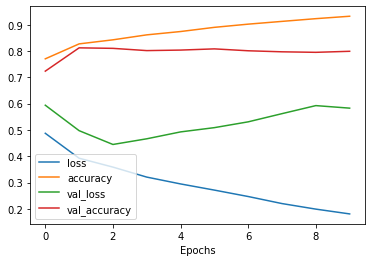

In [21]:
import tensorflow_hub as hub
# Making USE layer
USE_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                            input_shape=[], dtype=tf.string, trainable=False)

# Build model
model_5 = tf.keras.Sequential([
  USE_layer,
  layers.Dense(64, "relu"),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.Dense(1, "sigmoid")
])

# Compile model
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit model
history_5 = model_5.fit(X_train, y_train, epochs=10,
                        validation_data=(X_test, y_test),
                        callbacks=[create_tensorboard_callback("USE")])

# Plot validation accuracy
pd.DataFrame(history_5.history).plot();
plt.xlabel("Epochs")

## TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./TensorBoard_Experiments \
  --name "NLP modelling experiments on disaster tweets dataset" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot

View TensorBoard Records at https://tensorboard.dev/experiment/RWmJL5wrSVmBbFAaIN1jXw/ 